# VELOCITY CALCULATION 

This notebook shows the process to compute correctly the velocity of the spheres in the 2-D vibrating experiment from the DataFrame of the original linked trajectories data of the spheres along the frames of the experiment.


### STEPS TO COMPUTE AND PROCESS DATA
0. Import libraries and define functions
1. Load df linked file 
2. Filtering points within Rlim distance to discard particles near the platform border (requirement: obtain the center of the platform (via houghcircle function) and compute r for each particle) + reindex track ids
3. Filtering tracks via savgol
4. Compute velocities vx, vy with data from timeframe (2-steps process)
5. Calculate v and add to df
6. Obtain distribution functions
7. Compute Vmean and Kinetic Energy

### Import libraries

In [1]:
import sys
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pims
from pandas import DataFrame, Series  
import trackpy as tp
from scipy.signal import savgol_filter
import math
import skimage
import scipy as sp
from scipy import stats
import matplotlib.ticker as mtick

#interactive graphics
%matplotlib widget 

from mpl_toolkits.axes_grid1 import make_axes_locatable
from IPython.display import Image

### DEFINE FUNCTIONS

#### df_filR(rlim1,rlim2,df,frames)

The function filters the particles that are within a Rlim distance from the center of the vibrated platform. The output is a DataFrame with these particles.

INPUTS:

rlim1, rlim2: Values to determine the radius of the circular platform via skimage library function hough_radii.

frames: frames from .cine file of the experiment.

df: DataFrame with locations of the particles and linked into trajectories

OUTPUTS:

out: Dataframe with filtered positions 

In [19]:
def df_filR(rlim1,rlim2, df, frames):
    hough_radii=np.arange(rlim1,rlim2,1);
    hough_res=skimage.transform.hough_circle(frames[100],hough_radii);
    accums,cx,cy,radii=skimage.transform.hough_circle_peaks(hough_res,hough_radii,total_num_peaks=1);
    r=np.sqrt((df.x-cx)**2+(df.y-cy)**2);
    # rlim = radii from the detected circle - 17 frames-distance, equivalent to 3.5 sphere diameter
    rlim=(radii-17.5);
    df['r']=r;
    df=df[df.r<rlim[0]];
    df.drop('r', axis=1, inplace=True)
    
    return df

#### df_filSG(df,window_length)

The function filters the particle positions to smooth trajectories and avoid failures in the location process taking into account a window length. The output is a DataFrame with these particles.

INPUTS: 

df: DataFrame with locations of the particles and linked into trajectories

window_length: Length of the trajectory that are applied to the filter.

OUTPUTS:

out: Dataframe with filtered positions 

In [3]:
def df_filSG(df, window_length):
    #df=df.rename(columns={'particle':'track'})
    window_length=window_length;
    out = pd.DataFrame()
    for trajectory in set(df.track):
        sub = df[df.track==trajectory]
    
        if sub.shape[0] <= window_length+1:
        #Para obviar los casos en los que la trayectoria dura menos que la ventana de suavizado
            pass
        else:
            printp(f'Smoothing positions for track: {trajectory : .0f}')
            # Savgol filter
            sub['x'] = savgol_filter(sub['x'], window_length=window_length, polyorder=3, axis=0)
            sub['y'] = savgol_filter(sub['y'], window_length=window_length, polyorder=3, axis=0)          
            out=pd.concat([out,sub],ignore_index=True,axis=0)
    return out

def printp(string):
    """ Modification of print function to do everything on one line """
    import sys
    sys.stdout.write('\r'+ str(string))
    sys.stdout.flush()

#### velocity(df) & veltime(df, time)

The first function calculates the particle position variation between two consecutive frames.

The second function calculates the velocity dividing the position increment by the time increment.

INPUTS:

df: DataFrame with locations of the particles and linked into trajectories

time: Time of each frame

OUTPUTS:

1. out1: Dataframe with position increments
2. out2: Dataframe with velocities vx, vy


In [4]:
def velocity(df):
    out=pd.DataFrame()
    for i in range(ntracks):
        sub=df[df.track==i]
        vxvy = sub[['x','y']].diff(periods=-1)
        sub=sub[:-1]
        sub['vx']=vxvy.x
        sub['vy']=vxvy.y
        out=pd.concat([out,sub],ignore_index=True)
        if i%100==0:
            print(i)
    return out

def veltime(df,time):
    out=pd.DataFrame()
    for j in range(nt):
        sub=df[df.frame==j]
        vx=sub['vx']/(time[j+1]-time[j])
        vy=sub['vy']/(time[j+1]-time[j])
        sub['vx']=vx
        sub['vy']=vy
        out=pd.concat([out,sub],ignore_index=True)
        if j%100==0:
            print(j)
    return out

#### datavel (df)

The function calculates the module of the velocity for each particle in each frame and add a column to the DataFrame.

INPUTS:

df: DataFrame with locations of the particles and linked into trajectories

OUTPUTS:

df: DataFrame with velocity column

In [5]:
def datavel(df):
    v=(df.vx**2+df.vy**2)**(0.5);
    df['v']=v;
    
    return df

#### __tracks_len:__ get list of tracks ids; and no. of tracks

INPUT: data frame 'df' with tracks

OUTPUT: 
* lengths: array with lenghts of all tracks
* track_list: array with tracks IDs 
* ntracks: no. of tracks

#### __reindex_tracks:__ resets tracks IDs in logical order: 1,2,3...., ntracks

INPUT: 

* df: data frame with tracks
* arr: array with tracks list

OUTPUT: data frame with 'track' column modified

In [2]:
def tracks_len(df):
    track_list = np.unique(df.track.values) # list of current track_listk IDs
    ntracks = len(track_list)
    lengths = np.array( [len(df[df.track==i]) for i in track_list] ) # length of each track
    return track_list, lengths, ntracks


def reindex_tracks(df, arr):
    # replace tracks IDs with logical order count
    ntracks = len(arr)
    for i in range(ntracks):
        df.loc[df.track == arr[i],'track'] = i
    return df

## TEST V MEAN

## 1. LOAD DATA (linked df + frametime)

In [2]:
df=pd.read_pickle('/media/juan/DiscoDuro2G/Serie_Densidad_1.8sigma/Data Processed/datalinked_densidad0.05_f75Hz.pkl')
#frames=pims.open('/media/juan/DiscoDuro2G/Serie_Densidad_1.8sigma/densidad0.1_f75Hz.cine')
#time=np.loadtxt('/media/juan/DiscoDuro2G/Serie_Densidad_1.8sigma/Data Processed/frametime_densidad0.1_f75Hz.txt')

nt = np.max(df.frame.values) # number of frames (assumming there is at least one complete track)
df=df.rename(columns={'particle':'track'})

track_list = np.unique(df.track.values) # list of current track_listk IDs
ntracks = len(track_list)


In [3]:
df= df.sort_values(by=['track','frame']).reset_index(drop=True)

## 2. Compute velocities vx, vy 

In [4]:
vx=np.diff(df.x.values)
vy=np.diff(df.y.values)

In [5]:
df=df[:-1]

In [6]:
df['vx']=vx.tolist()
df['vy']=vy.tolist()

In [7]:
ids=df[df.frame==nt].track

In [8]:
dfred=df[~df['track'].isin(ids)]

In [9]:
dif=np.diff(dfred.track.values)

In [10]:
dif=np.append(dif,1)

In [11]:
dfred['dif']=dif.tolist()

/tmp/ipykernel_38223/644281384.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfred['dif']=dif.tolist()


In [12]:
ids_test=dfred[dfred.dif>=1].index

Es así como puedo eliminar las filas que tienen valores de V no reales (por el hecho de hacerlo por dif.)

In [13]:
dfred=dfred[~dfred.index.isin(ids_test)]

In [14]:
dfred=dfred.drop(columns='dif')

In [15]:
df=df[df['track'].isin(ids)]

In [16]:
df=df[df.frame<nt]

In [17]:
df=pd.concat([df,dfred],ignore_index=True)

In [18]:
df=df.sort_values(by=['track','frame']).reset_index(drop=True)

In [19]:
df.to_pickle('/media/juan/DiscoDuro2G/Serie_Densidad_1.8sigma/Data Processed/datalinked_proces_npdif_densidad0.05_f75Hz.pkl')

## 3. Calculate v with real times from time_frame

In [6]:
df2=pd.read_pickle('/media/juan/DiscoDuro2G/Serie_Densidad_1.8sigma/Data Processed/datalinked_processed_densidad0.1_f75Hz.pkl')

In [4]:
time=np.loadtxt('/media/juan/DiscoDuro2G/Serie_Densidad_1.8sigma/Data Processed/frametime_densidad0.1_f75Hz.txt')

In [3]:
nt = np.max(df.frame.values)

In [8]:
out=pd.DataFrame()
for j in range(nt):
    sub=df[df.frame==j]
    vx=sub['vx']/(time[j+1]-time[j])
    vy=sub['vy']/(time[j+1]-time[j])
    sub['vx']=vx
    sub['vy']=vy
    out=pd.concat([out,sub],ignore_index=True)
    if j%100==0:
        print(j)
        

df=out

/tmp/ipykernel_87187/861430079.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['vx']=vx
/tmp/ipykernel_87187/861430079.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['vy']=vy


0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
18

In [9]:
df.to_pickle('/media/juan/DiscoDuro2G/Serie_Densidad_1.8sigma/Data Processed/datalinked_proces_npdif_time_densidad0.1_f75Hz.pkl')

## 4. Compute kinetic energy  
<v²> = <vx²>+<vy²> for each frame

In [10]:
v2x=np.zeros(nt)
v2y=np.zeros(nt)
v2=np.zeros(nt)

for i in range(nt):
    v2x[i]=np.mean(df[df.frame==i].vx.values**2)
    v2y[i]=np.mean(df[df.frame==i].vy.values**2)
    if i%100==0:
        print (i)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
18

In [24]:
np.savetxt('/media/juan/DiscoDuro2G/Serie_Densidad_1.8sigma/Data Processed/v2x_0.1.txt',v2x)
np.savetxt('/media/juan/DiscoDuro2G/Serie_Densidad_1.8sigma/Data Processed/v2y_0.1.txt',v2y)

In [13]:
v=np.sqrt(df['vx']**2+df['vy']**2)

In [23]:
v2x

array([23864.91382867, 22693.82055786, 14794.08309048, ...,
       26144.04437286, 17495.17223671, 14483.86186289])

In [15]:
v2=v2x+v2y

In [19]:
hx, bordesx= np.histogram(df['vx'].values,bins=200,density=True)
hy, bordesy= np.histogram(df['vy'].values,bins=200,density=True)
h, bordes= np.histogram(v,bins=200,density=True)

Text(0, 0.5, '$v_i^2$')

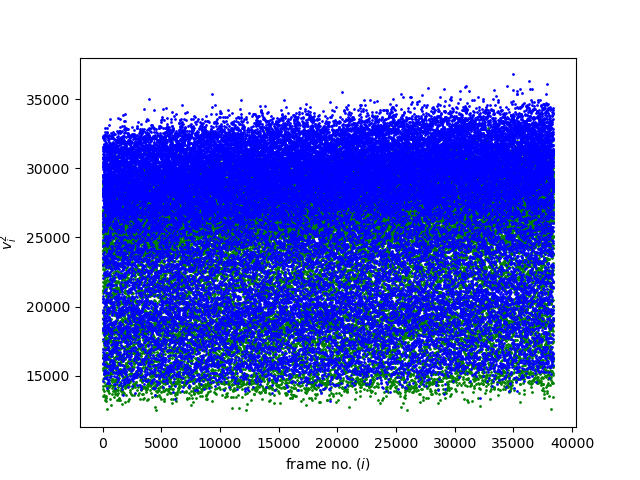

In [17]:
plt.figure()
plt.plot(v2x,'.',c='g',markersize=2)
plt.plot(v2y,'.',c='b',markersize=2)
#plt.plot(v2[:10000],'.',c='r',markersize=2)
plt.xlabel(r'$\mathrm{frame~no.} (i)$')
plt.ylabel(r'$v_i^2$')

Text(0, 0.5, '$v_i^2$')

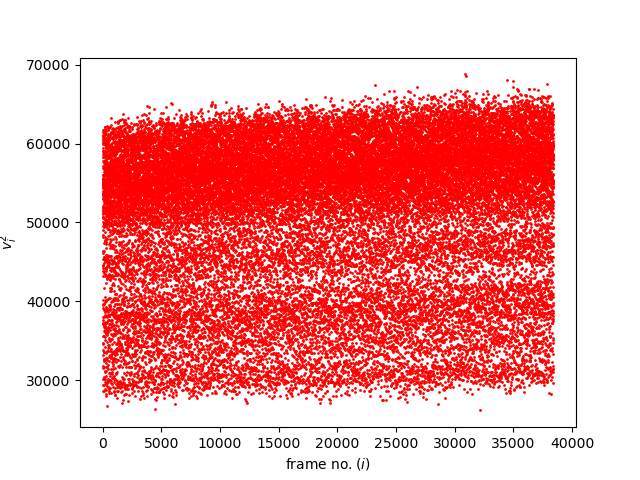

In [16]:
plt.figure()
#plt.plot(v2x[:2200],'.',c='g',markersize=2)
#plt.plot(v2y[:2200],'.',c='b',markersize=2)
plt.plot(v2,'.',c='r',markersize=2)
plt.xlabel(r'$\mathrm{frame~no.} (i)$')
plt.ylabel(r'$v_i^2$')

(-750.0, 750.0)

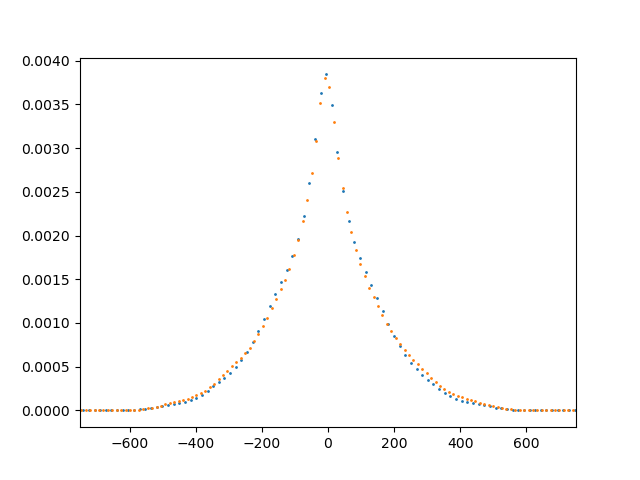

In [20]:
plt.figure()
plt.plot(bordesx[:-1],hx,'.',markersize=2)
plt.plot(bordesy[:-1],hy,'.',markersize=2)
plt.xlim(-750,750)

(0.0, 1000.0)

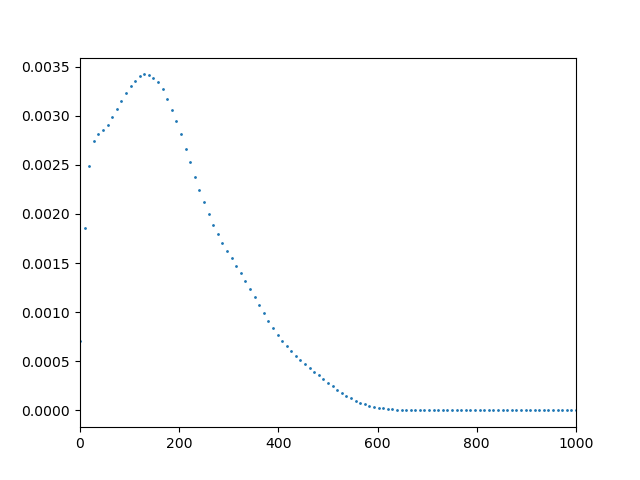

In [22]:
plt.figure()
plt.plot(bordes[:-1],h,'.',markersize=2)
plt.xlim(0,1000)

In [21]:
np.sum(h)*(bordes[10]-bordes[9])

0.9999999999999998